In [1]:
# Step 1: Install dependencies (if needed)
!pip install scikit-learn pandas

# Step 2: Import Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score



# Step 4: Load the dataset
df = pd.read_csv("/content/cleaned_flight_data_with_labels.csv")

# Step 5: Select only required input and target columns
features = ['long', 'lat', 'alt', 'model', 'mph', 'reg_city', 'reg_state']
target = 'Label'
df = df[features + [target]]

# Step 6: Encode categorical features and target label
le_model = LabelEncoder()
le_city = LabelEncoder()
le_state = LabelEncoder()
le_label = LabelEncoder()

df['model'] = le_model.fit_transform(df['model'])
df['reg_city'] = le_city.fit_transform(df['reg_city'])
df['reg_state'] = le_state.fit_transform(df['reg_state'])
df['Label'] = le_label.fit_transform(df['Label'])

# Step 7: Split features and target
X = df.drop(columns=[target])
y = df[target]

# Step 8: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 9: Train the Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 10: Evaluate the model
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le_label.classes_))

# Optional: Save the model
import joblib
joblib.dump(model, 'rc_risk_predictor.pkl')


Accuracy: 0.9993537964458804
Classification Report:

              precision    recall  f1-score   support

highest risk       1.00      1.00      1.00       322
    moderate       1.00      1.00      1.00      2973
        risk       1.00      1.00      1.00      2324
        safe       1.00      0.99      1.00       571

    accuracy                           1.00      6190
   macro avg       1.00      1.00      1.00      6190
weighted avg       1.00      1.00      1.00      6190



['rc_risk_predictor.pkl']

In [3]:
import joblib

joblib.dump(le_model, "le_model.pkl")
joblib.dump(le_city, "le_city.pkl")
joblib.dump(le_state, "le_state.pkl")
joblib.dump(le_label, "le_label.pkl")


['le_label.pkl']

Dataset shape: (30947, 8)

Risk Label distribution:
Label
1    14909
2    11909
3     2635
0     1494
Name: count, dtype: int64


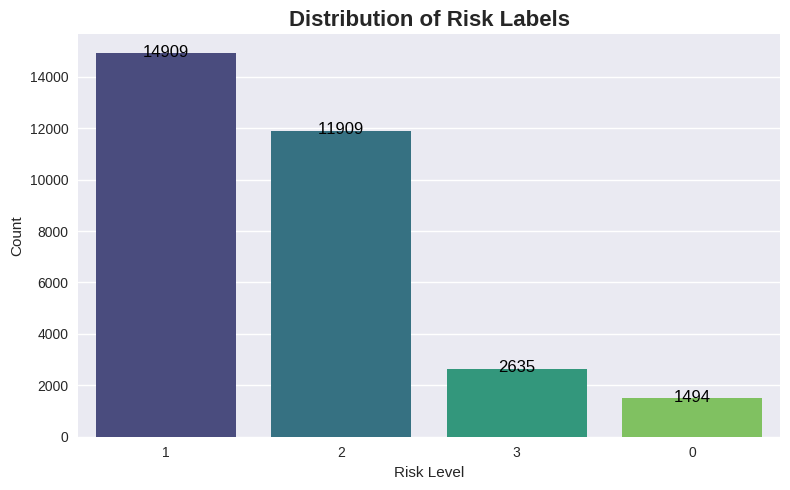

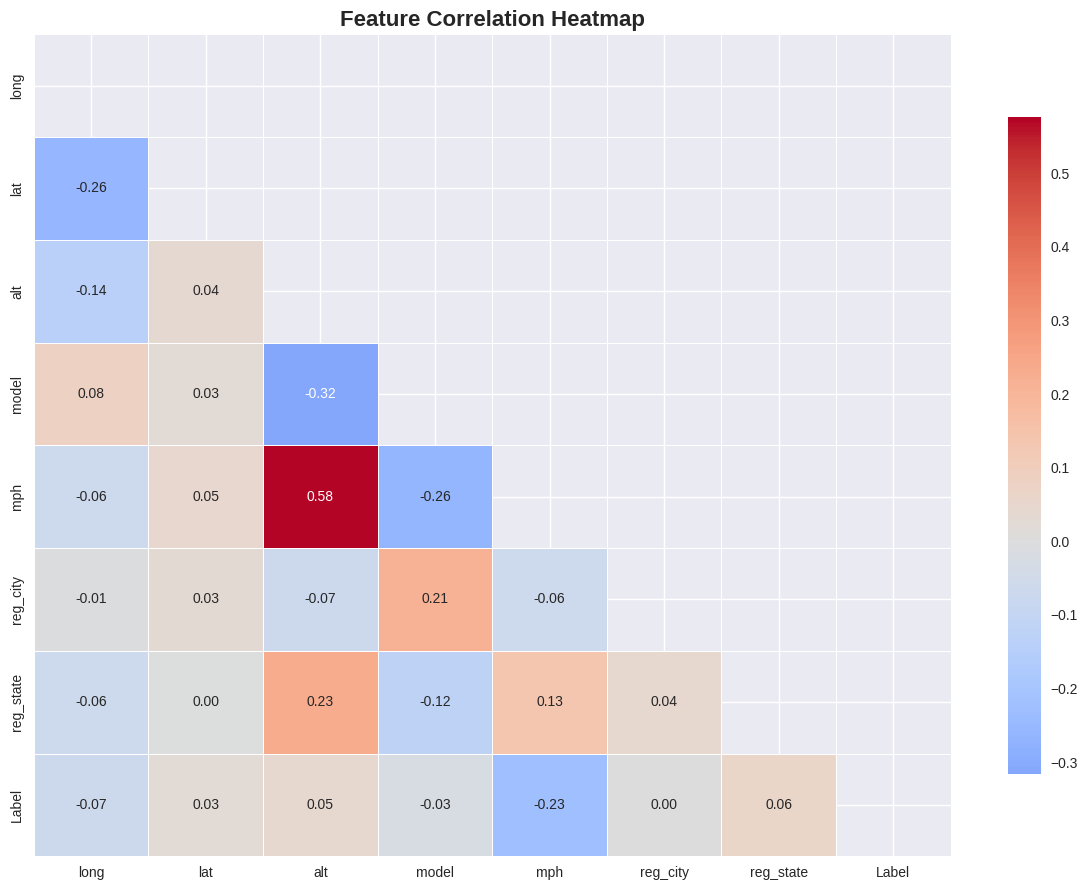

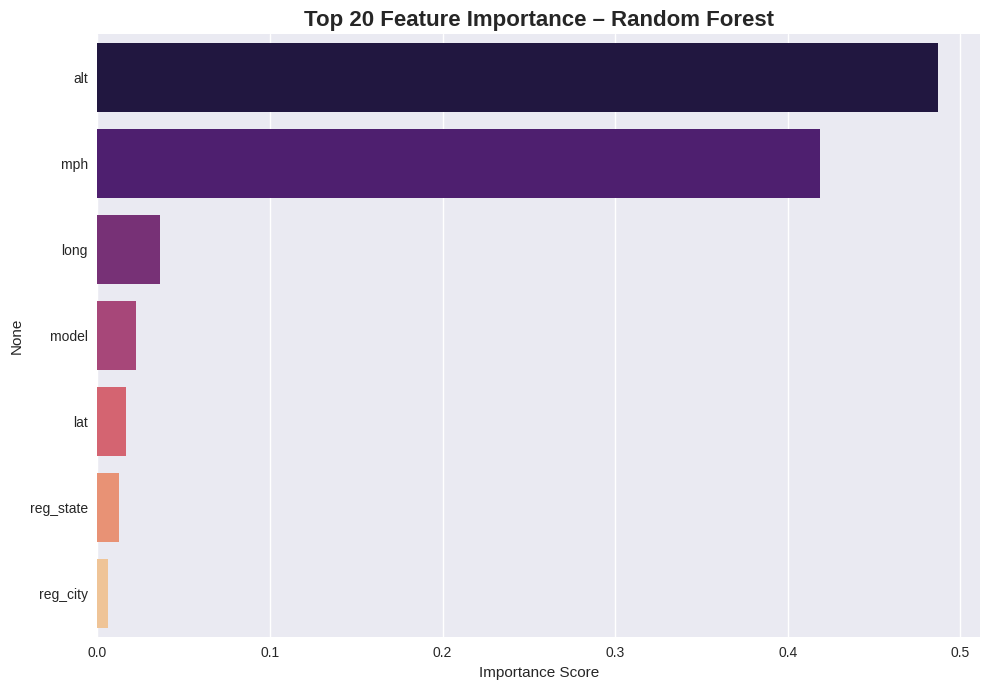

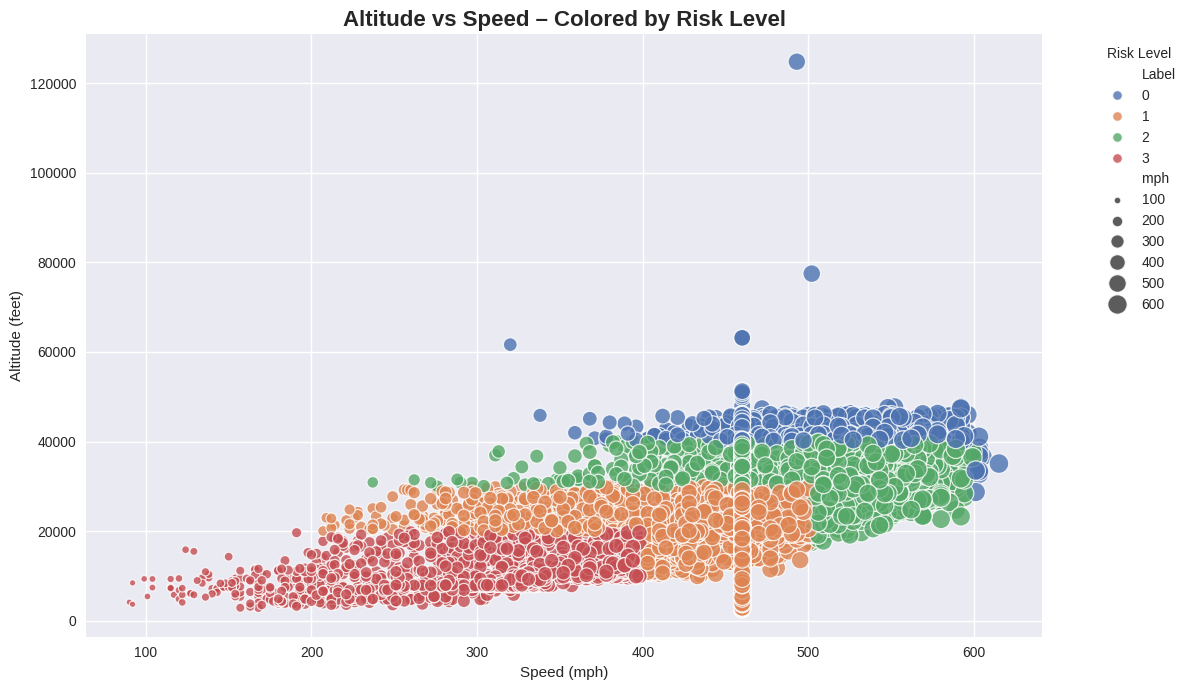

SyntaxError: keyword argument repeated: hue (ipython-input-2440378465.py, line 100)

In [8]:
# =====================================================
# FLIGHT RISK ANALYSIS – BEST VISUALIZATIONS (Fixed & Clean)
# =====================================================

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd
import numpy as np
import warnings
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

warnings.filterwarnings("ignore")

# Styling
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

# ==================== LOAD DATA ====================
df_orig = pd.read_csv("/content/cleaned_flight_data_with_labels.csv")           # encoded version (for correlation / importance)
df_orig = df.copy()  # keep original categorical columns for nice plots

# Adjust these lists according to your actual columns
features = ['long', 'lat', 'alt', 'mph', 'model', 'reg_city', 'reg_state']
target   = 'Label'

df_orig = df_orig[features + [target]]

print("Dataset shape:", df_orig.shape)
print("\nRisk Label distribution:")
print(df_orig['Label'].value_counts())

# ==================== 1. Class Distribution ====================
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df_orig, x='Label', order=df_orig['Label'].value_counts().index, palette="viridis")
plt.title('Distribution of Risk Labels', fontsize=16, fontweight='bold')
plt.xlabel('Risk Level')
plt.ylabel('Count')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width()/2., p.get_height() + 50),
                ha='center', va='center', fontsize=12, color='black')
plt.tight_layout()
plt.show()

# ==================== 2. Correlation Heatmap ====================
plt.figure(figsize=(12, 9))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', center=0,
            fmt='.2f', linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# ==================== 3. Random Forest Feature Importance ====================
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

plt.figure(figsize=(10, 7))
sns.barplot(x=importances[indices][:20], y=feature_names[indices][:20], palette='magma')
plt.title('Top 20 Feature Importance – Random Forest', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# ==================== 4. Interactive 3D Scatter ====================
fig = px.scatter_3d(df_orig,
                    x='long', y='lat', z='alt',
                    color='Label',
                    size='mph',
                    hover_data=['model', 'reg_city', 'reg_state'],
                    color_discrete_sequence=px.colors.qualitative.Bold,
                    title='3D Flight Positions – Colored by Risk (Size = Speed)')
fig.update_layout(scene=dict(xaxis_title='Longitude',
                             yaxis_title='Latitude',
                             zaxis_title='Altitude (ft)'),
                  height=800)
fig.show()

# ==================== 5. Altitude vs Speed ====================
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df_orig, x='mph', y='alt', hue='Label',
                size='mph', sizes=(20, 200), alpha=0.8, palette='deep')
plt.title('Altitude vs Speed – Colored by Risk Level', fontsize=16, fontweight='bold')
plt.xlabel('Speed (mph)')
plt.ylabel('Altitude (feet)')
plt.legend(title='Risk Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ==================== 6. Pairplot – FIXED LINE ====================
numerical_cols = ['long', 'lat', 'alt', 'mph']
sns.pairplot(df_orig,
             vars=numerical_cols,
             hue='Label',
             hue='Label',
             diag_kind='kde',
             corner=True,
             plot_kws={'alpha': 0.6, 's': 50},
             diag_kws={'fill': True})          # ← This line is now 100% correct
plt.suptitle('Pairplot of Numerical Features by Risk Label', y=1.02, fontsize=16, fontweight='bold')
plt.show()

# ==================== 7. Confusion Matrix ====================
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_label.classes_,
            yticklabels=le_label.classes_)
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# ==================== 8. Precision-Recall Curve (Multi-class) ====================
y_test_bin = label_binarize(y_test, classes=range(len(le_label.classes_)))
y_pred_proba = model.predict_proba(X_test)

plt.figure(figsize=(10, 7))
for i, label in enumerate(le_label.classes_):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_proba[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_pred_proba[:, i])
    plt.plot(recall, precision, lw=2, label=f'{label} (AP = {ap:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve per Class', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ==================== 9. Top 20 Cities & States by Risk ====================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Cities
city_counts = df_orig.groupby(['reg_city', 'Label']).size().unstack(fill_value=0)
top_cities = city_counts.sum(axis=1).sort_values(ascending=False).head(20).index
city_counts.loc[top_cities].plot(kind='barh', stacked=True, ax=ax1, cmap='tab20')
ax1.set_title('Top 20 Registration Cities (Stacked by Risk)', fontweight='bold')
ax1.set_xlabel('Number of Flights')
ax1.invert_yaxis()

# States
state_counts = df_orig.groupby(['reg_state', 'Label']).size().unstack(fill_value=0)
top_states = state_counts.sum(axis=1).sort_values(ascending=False).head(20).index
state_counts.loc[top_states].plot(kind='barh', stacked=True, ax=ax2, cmap='Set3')
ax2.set_title('Top 20 Registration States (Stacked by Risk)', fontweight='bold')
ax2.set_xlabel('Number of Flights')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

# ==================== BONUS: Global Risk Map ====================
fig = px.scatter_geo(df_orig,
                     lat='lat',
                     lon='long',
                     color='Label',
                     size='mph',
                     hover_name='model',
                     hover_data=['reg_city', 'reg_state', 'alt'],
                     title='Global Flight Risk Heatmap',
                     color_discrete_sequence=px.colors.qualitative.Dark24,
                     size_max=15)

fig.update_geos(showland=True, landcolor="lightgray",
                showocean=True, oceancolor="LightSkyBlue",
                showcountries=True, countrycolor="gray")
fig.update_layout(height=700, margin=dict(r=0, t=40, l=0, b=0))
fig.show()